In [1]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import TimeoutException
from selenium.common.exceptions import NoSuchElementException
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import Select
import time
import requests
from bs4 import BeautifulSoup

import pandas as pd
import numpy as np
import re

import openpyxl
import os
import sys
import time
import json
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By

from geopy.geocoders import Nominatim

import warnings
warnings.filterwarnings('ignore')

In [10]:
driver = webdriver.Chrome("chromedriver")
url = "https://map.kakao.com/"
driver.get(url)

searchbox = driver.find_element(By.ID, 'search.keyword.query')
searchbox.send_keys('서울대 음식점')

searchbutton = driver.find_element(By.ID, 'search.keyword.submit')
driver.execute_script('arguments[0].click();', searchbutton)
time.sleep(2)

# sort = driver.find_element(By.CSS_SELECTOR, 'a.label.ACTIVE')
sort = driver.find_element(By.XPATH, '//*[@id="info.search.place.sort"]/li[2]/a')
driver.execute_script('arguments[0].click();', sort)
# sort.click()
time.sleep(1.5)

In [13]:
def kakao(key) :
    
    driver = webdriver.Chrome("chromedriver")
    url = "https://map.kakao.com/"
    driver.get(url)

    searchbox = driver.find_element(By.ID, 'search.keyword.query')
    searchbox.send_keys(key)

    searchbutton = driver.find_element(By.ID, 'search.keyword.submit')
    driver.execute_script('arguments[0].click();', searchbutton)
    time.sleep(2)
    
    sort = driver.find_element(By.XPATH, '//*[@id="info.search.place.sort"]/li[2]/a')
    driver.execute_script('arguments[0].click();', sort)
    time.sleep(1.5)

    more = driver.find_element(By.ID, 'info.search.place.more')
    driver.execute_script('arguments[0].click();', more)
    time.sleep(2)

    kakao_df = pd.DataFrame()
    
    for j in range(1) :
    
        title = []
        category = []
        rating = []
        rating_num = []
        review = []
        address = []

        for i in range(5) :

            page = driver.find_element(By.ID, 'info.search.page.no{}'.format(i+1))
            driver.execute_script('arguments[0].click();', page)
            time.sleep(2)
            title_element = "ul.placelist>li.PlaceItem.clickArea>div.head_item.clickArea>strong.tit_name"
            cate_element = "ul.placelist>li.PlaceItem.clickArea>div.head_item.clickArea>span.subcategory.clickable"
            rating_element = "ul.placelist>li.PlaceItem.clickArea>div.rating.clickArea>span.score>em.num"
            ratingnum_element = "ul.placelist>li.PlaceItem.clickArea>div.rating.clickArea>span.score>a.numberofscore"
            re_element = "ul.placelist>li.PlaceItem.clickArea>div.rating.clickArea>a.review>em"
            add_element = "ul.placelist>li.PlaceItem.clickArea>div.info_item>div.addr"

            for x in driver.find_elements(By.CSS_SELECTOR, title_element) :
                title.append(x.text)

            for x in driver.find_elements(By.CSS_SELECTOR, cate_element) :
                category.append(x.text)
                
            for x in driver.find_elements(By.CSS_SELECTOR, rating_element) :
                rating.append(x.text)    

            for x in driver.find_elements(By.CSS_SELECTOR, ratingnum_element) :
                rating_num.append(x.text)

            for x in driver.find_elements(By.CSS_SELECTOR, re_element) :
                review.append(x.text)

            for x in driver.find_elements(By.CSS_SELECTOR, add_element) :
                address.append(x.text)                

            df0 = pd.DataFrame({'Store' : title, 'Category' : category, 
                               'Rating' : rating, 'RatingNum' : rating_num, 'Review' : review, 'Address' : address})
        
        kakao_df = pd.concat([kakao_df, df0], axis = 0)

        nxt = driver.find_element(By.ID, 'info.search.page.next')
        driver.execute_script('arguments[0].click();', nxt)
        time.sleep(2)
    
    driver.close() 

    return kakao_df

def preprocess(df) :
    df0 = df.copy()
    lst = []
    for x in df['Store'] :
        lst.append(' '.join(x.split(' ')[1:]))
    
    df0['Store'] = lst
    
    re = []
    for x in df['Review'] :
        re.append(int(x.replace(',', '')))
    df0['Review'] = re
    
    return df0

In [14]:
df = kakao('서울대 음식점')
df0 = preprocess(df)
df0 = df0.reset_index(drop = True)
df0.shape

(75, 6)

In [15]:
df0.head()

,Store,Category,Rating,RatingNum,Review,Address
0,쟝블랑제리,"제과,베이커리",3.7,366건,854,서울 관악구 낙성대역길 8\n(지번) 봉천동 1660-7
1,고기굽는사람들 샤로수길본점,"육류,고기",4.4,172건,119,서울 관악구 관악로14길 70 1층\n(지번) 봉천동 1619-1
2,킷사서울,일식,3.0,125건,584,서울 관악구 남부순환로226길 31 2층\n(지번) 봉천동 1603-3
3,기절초풍왕순대,순대,3.9,110건,231,"서울 관악구 봉천로62길 2 1,2층\n(지번) 봉천동 1620-38"
4,논밭골 봉천점,갈비,3.3,48건,66,서울 관악구 청룡길 30\n(지번) 봉천동 915-26


In [32]:
def review_text(key, scroll):
    driver = webdriver.Chrome("chromedriver")
    url = "https://map.kakao.com/"
    driver.get(url)

    searchbox = driver.find_element(By.ID, 'search.keyword.query')
    searchbox.send_keys('서울 {}'.format(key))


    searchbutton = driver.find_element(By.ID, 'search.keyword.submit')
    driver.execute_script('arguments[0].click();', searchbutton)
    time.sleep(2)

    new_path = '//*[@id="info.search.place.list"]/li/div[4]/a'
    new_window = driver.find_element(By.XPATH, new_path)
    driver.execute_script('arguments[0].click();', new_window)
    time.sleep(2)

    driver.switch_to.window(driver.window_handles[-1])
    time.sleep(3)

    for i in range(scroll) :
        more = driver.find_elements(By.CSS_SELECTOR, 'span.txt_more')[0]
        driver.execute_script('arguments[0].click();', more)
        time.sleep(1)

    review = driver.find_elements(By.CSS_SELECTOR, 'p.txt_comment.txt_fold')

    re_lst = []
    for x in review :
        re_lst.append(x.text)
        
    # 메뉴, 가격
    if driver.find_elements(By.CSS_SELECTOR, 'span.loss_word') :
        
        menu = driver.find_elements(By.CSS_SELECTOR, 'span.loss_word')[0].text
        price = driver.find_elements(By.CSS_SELECTOR, 'em.price_menu')[0].text
    else :
        menu = 'X'
        price = 'X'

    time.sleep(2)
    driver.quit()
    
    return menu, price, re_lst

In [33]:
df_part2 = df0[:20]

review_lst = []
menu_lst = []
price_lst = []


for i in range(len(df_part2)) :
    key = df_part2.loc[i, 'Store']
    scroll = (df_part2.loc[i, 'Review'] - 3) // 5
    
    menu, price, review = review_text(key, scroll)
    
    review_lst.append(review)
    menu_lst.append(menu)
    price_lst.append(price)

df_part2['review_txt'] = review_lst
df_part2['menu'] = menu_lst
df_part2['price'] = price_lst

In [34]:
df_part2

,Store,Category,Rating,RatingNum,Review,Address,review_txt,menu,price
0,쟝블랑제리,"제과,베이커리",3.7,366건,854,서울 관악구 낙성대역길 8\n(지번) 봉천동 1660-7,[빵은 맛있는데\n캐셔 보는 직원분들 졸라 싸가지 없네 진짜\n4점 줬다가 1점으로...,X,X
1,고기굽는사람들 샤로수길본점,"육류,고기",4.4,172건,119,서울 관악구 관악로14길 70 1층\n(지번) 봉천동 1619-1,[부드러운 고기와 달달한 양념 갈비. \n딱 무한 리필의 기본을 잘 지키고 있었습니...,차돌라면,"5,900"
2,킷사서울,일식,3.0,125건,584,서울 관악구 남부순환로226길 31 2층\n(지번) 봉천동 1603-3,[일단 가격 인상이 있어서 가성비 부분은 뺐지만 음식은 괜찮아요 양도 적당하구요. ...,단뽀뽀 오므라이스,"11,000"
3,기절초풍왕순대,순대,3.9,110건,231,"서울 관악구 봉천로62길 2 1,2층\n(지번) 봉천동 1620-38",[순대국에 고기가 푸짐하게 들어있어서 깜짝 놀랬습니다! 잡내 안나고 맛있습니다 \n...,왕순대,"18,000"
4,논밭골 봉천점,갈비,3.3,48건,66,서울 관악구 청룡길 30\n(지번) 봉천동 915-26,[고기 질은 좋은편이였으나\n가격이 사악했음\n배부르게 먹기엔 좀 \n가격만 내리면...,왕갈비탕,"12,000"
5,오월의김밥,분식,4.4,151건,350,서울 관악구 봉천로 605\n(지번) 봉천동 1657-21,[부재료 까이이득 들은 아주 듬직한 김밥!! \n기대하고 먹었는데도 실망없는 맛이였...,밥도둑김밥,"5,000"
6,외래향 서울대점,중국요리,3.3,117건,122,서울 관악구 남부순환로 1801 2층 201호\n(지번) 봉천동 874-4,[몇년전에 처음 와보고 맛있게 먹고 주변 사람들이 맛집 추천해달라 하면 항상 추천했...,자장면,"7,000"
7,동명 IZAKAYA,일본식주점,4.6,33건,197,서울 관악구 남현1길 42 남현빌딩 4층\n(지번) 남현동 1062-23,[서빙 해주시는 분이 굉장히 센스 있으세요. 필요한 것들 말씀 안드려도 척척 가져다...,사시미 모리아와세 中,"40,000"
8,텐동요츠야,일식,3.7,350건,534,서울 관악구 관악로14길 35 1층\n(지번) 봉천동 1603-19,[평일 저녁 오픈 10분 전에 도착해서 30분 웨이팅하고 자리 앉은 후 10분 기다...,에비죠텐동,"13,500"
9,제주상회,국수,4.3,103건,131,서울 관악구 관악로12길 108 지하 1층\n(지번) 봉천동 1625-1,[특별한 맛집은 아닌듯\n제주도 한달살기 시절 생각하고 갔는데\n그냥 고기국수\n면...,고기국수,"9,000"


In [36]:
df_part2.to_csv('서울대_20.csv')

In [3]:
from nltk.tokenize import word_tokenize, WordPunctTokenizer
from konlpy.tag import Okt, Mecab, Kkma

from wordcloud import WordCloud
from collections import Counter
from PIL import Image
from eunjeon import Mecab

import re
import time
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import stylecloud

import warnings
warnings.filterwarnings('ignore')

In [4]:
df = pd.read_csv('서울대_20.csv')

In [69]:
new = []
mecab = Mecab()

with open('stopword.txt', 'r', encoding = 'utf8') as f:
    stop = f.read()
stop =  stop.split('\n')
add = ['는데', '네요', '어요', '너무', '아서', '보다', '해서', '다고', '정말', '많이', '맛있']
stop = stop + add

for txt in df['review_txt'] :
    
    text = re.compile('[^가-힣\s]').sub('', str(txt))
    
    text = mecab.pos(text)
    
    text = [x[0] for x in text if x[0] not in stop]
    text = [x for x in text if len(x) > 1]
    
    new.append(text)
    
df['new_text'] = new
df.head()

,Unnamed: 0,Store,Category,Rating,RatingNum,Review,Address,review_txt,menu,price,new_text
0,0,명동교자 본점,분식,3.6,913건,2234,서울 중구 명동10길 29\n(지번) 명동2가 25-36,['솔직히 여기 다들 왜 이러는지는 모르겠는데 4살부터 갔었는데 진짜 존맛탱이고 사...,콩국수(포장불가능),"11,000","[솔직히, 이러, 는지, 모르, 갔었, 진짜, 사이즈, 진대, 그대로, 바선, 사건..."
1,1,진미평양냉면,냉면,3.7,284건,831,서울 강남구 학동로 305-3 정각빌딩 1층\n(지번) 논현동 115-10,"['나는 좋았다 어복쟁반도 맛있고\n유명한 집이니 한 번쯤 방문하는 것도 괜찮을듯,...",편육,"32,000","[어복쟁반, 유명, 방문, 괜찮, 가야지, 워낙, 사람, 마다, 입맛, 달라서, 강..."
2,2,중앙해장,해장국,3.9,408건,944,서울 강남구 영동대로86길 17 육인빌딩 1층\n(지번) 대치동 996-16,['토요일 이른저녁시간에 1시간 웨이팅 하고 들어갔습니다. 셋이서 전골대자에 볶음밥...,한우양선지 해장국,"12,000","[토요일, 이른, 저녁, 웨이팅, 들어갔, 골대, 볶음밥, 부르, 곱창, 넉넉, 국..."
3,3,어니언 안국점,카페,3.5,214건,1437,서울 종로구 계동길 5\n(지번) 계동 146-1,['여기 직원분들이 너무너무너무 친절하십니다! 사소한 부분들일수도 있지만 말투가 다...,Americano,"5,000","[직원, 너무너무, 친절, 십니다, 사소, 부분, 말투, 이쁘, 행동, 모든, 상냥..."
4,4,노티드 청담,디저트카페,3.8,317건,2122,서울 강남구 도산대로53길 15 1층\n(지번) 신사동 654-9,['선물용 시그니처케익 케이스에 작은 초파리하나 죽은게 붙어 있어 교환요청했는데 빠...,우유 생크림 도넛,"3,500","[선물, 케익, 케이스, 초파리, 교환, 요청, 빠른, 처리, 감사, 합니다, 포장..."


In [67]:
# df0 = df[:5]
# #     img_array = np.array(img)
# #     x = np.where(img_array == 0, 255, 0)
# #         wc = WordCloud(font_path = 'malgun', background_color="white", 
# #                    width = 500, height = 500, max_font_size = 250, mask = x, color_func = color)
# def wc(i) :
# #     img = Image.open('지도.png')
# #     img_array = np.array(img)
# #     x = np.where(img_array == 0, 255, 0)
    
#     wc = Counter(df.loc[i, 'new_text'])
# #     cloud = stylecloud.gen_stylecloud(font_path = "malgun", icon_name = "fas fa-dog", width = 400, height = 400, max_font_size = 100, background_color = 'white')#, mask = x,  )
#     cloud = stylecloud.gen_stylecloud(text = wc, font_path = "malgun", icon_name = "fas fa-dog", background_color = 'white')
#     gen = cloud.generate_from_frequencies(wc)
    
#     return gen

# for i in range(len(df0)) :
#     gen = wc(i)

#     plt.figure()  
#     plt.title(df.loc[i, 'Store'])
#     plt.imshow(gen)
#     plt.axis('off')

In [51]:
df0['Store']

0    명동교자 본점
1     진미평양냉면
2       중앙해장
3    어니언 안국점
4     노티드 청담
Name: Store, dtype: object

In [68]:
# https://www.joydeepdeb.com/misc/font-awesome-5.html
coffee = "fas fa-coffee"
spoon = "fas fa-utensil-spoon"
pizza = "fas fa-pizza-slice"
beer = "fas fa-beer"
fish = "fas fa-fish"
hambuger = "fas fa-hamburger"
spoon2 = "fas fa-utensils"
df0 = df[:1]

for i in range(len(df0))   :
    
    wc = dict(Counter(df.loc[i, 'new_text']).most_common(150))
    cloud = stylecloud.gen_stylecloud(text = wc, font_path = "malgun", icon_name = "fas fa-utensils", background_color = 'white', 
                                     output_name = '{}.png'.format(df0.loc[i, 'Store']))



In [150]:
import tqdm
import torch
import pandas as pd
import matplotlib.pyplot as plt
from torch.optim import AdamW
from torch.utils.data import TensorDataset, DataLoader
from transformers import AutoModelForSequenceClassification, AutoTokenizer, get_scheduler
from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split

In [151]:
class MyLightningModule(LightningModule):
    
    def __init__(self):
        super().__init__()
        self.model = AutoModelForSequenceClassification.from_pretrained(
            "monologg/koelectra-small-v3-discriminator",
            num_labels=1,
            problem_type="multi_label_classification"
        )
        
    
    def training_step(self, batch, batch_idx):
        output = self.model(input_ids=batch[0], attention_mask=batch[1], labels=batch[2].unsqueeze(1))
        self.log("train/loss", output.loss)
        self.log("train/accuracy", ((output.logits.squeeze() > 0).long() == batch[2]).float().mean())
        return output.loss

    def validation_step(self, batch, batch_idx):
        output = self.model(input_ids=batch[0], attention_mask=batch[1], labels=batch[2].unsqueeze(1))
        self.log("val/loss", output.loss)
        self.log("val/accuracy", ((output.logits.squeeze() > 0).long() == batch[2]).float().mean(), prog_bar=True)

    def parameter_groups(self):
        do_decay = [p for p in self.parameters() if p.ndim >= 2]
        no_decay = [p for p in self.parameters() if p.ndim < 2]
        return [{"params": do_decay}, {"params": no_decay, "weight_decay": 0.0}]

    def configure_optimizers(self):
        optimizer = AdamW(self.parameter_groups(), lr=1e-5, weight_decay=0.01)
        scheduler = get_scheduler(optimizer = optimizer, name="linear", num_warmup_steps=10000, num_training_steps=100000)
        return [optimizer], [{"scheduler": scheduler, "interval": "step"}]

In [152]:
df = pd.read_csv('대화_data.csv')
df['Emotion'].value_counts()
lst = ['행복', '분노', '혐오','중립']
df = df[df['Emotion'].isin(lst)]

df = df.replace({'행복' : 1, '분노' : 0, '혐오' : 0, '중립' : 0.5}).reset_index(drop = True)
df['Emotion'].value_counts()
df.head()

,Sentence,Emotion
0,서해 수자원도 한류라서 그동안 불법조업 방치했나?,0.0
1,니가 인간이가.,0.0
2,강아지를 때리고 유기하는것만 학대는 아닙니다!,0.0
3,하여간 우리나라 교육엔 미래가 없어!!,0.0
4,채널에이 군부 개인거 인증하냐 동아일보야!!,0.0


In [153]:
add = pd.read_csv('ChatbotData.csv')
add = add[add['label'] == 2][['A', 'label']].rename(columns = {'A' : 'Sentence', 'label' : 'Emotion'}).replace(2, 1).reset_index(drop = True)
df = pd.concat([df, add],axis = 0).reset_index(drop = True)

In [154]:
df = df[df['Emotion'] != 0.5]
df['Emotion'].value_counts()

0.0    11094
1.0     9000
Name: Emotion, dtype: int64

In [155]:
df.isnull().sum()

Sentence    0
Emotion     0
dtype: int64

In [156]:
tokenizer = AutoTokenizer.from_pretrained("monologg/koelectra-small-v3-discriminator")

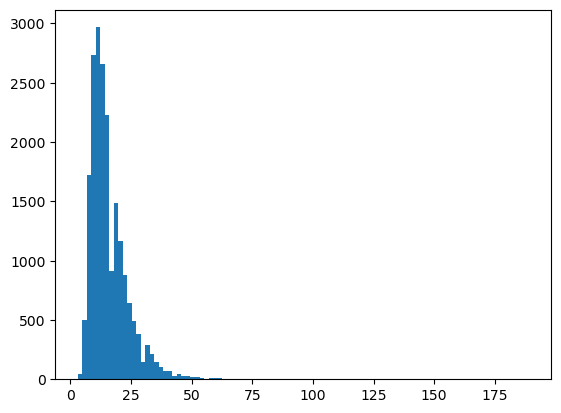

In [157]:
plt.hist(list(map(len, tokenizer(df.Sentence.tolist()).input_ids)), bins=100)
plt.show()

In [158]:
train_df, val_df = train_test_split(df, test_size = 0.2, shuffle=True, stratify=df.Emotion, random_state = 306)

In [159]:
train_df['Emotion'].value_counts(), val_df['Emotion'].value_counts()

(0.0    8875
 1.0    7200
 Name: Emotion, dtype: int64,
 0.0    2219
 1.0    1800
 Name: Emotion, dtype: int64)

In [160]:
train = tokenizer(train_df.Sentence.tolist(), max_length=32, truncation=True, padding="max_length", return_tensors="pt")
val = tokenizer(val_df.Sentence.tolist(), max_length=32, truncation=True, padding="max_length", return_tensors="pt")

In [161]:
train_dataloader = DataLoader(
    TensorDataset(train.input_ids, train.attention_mask, torch.from_numpy(train_df.Emotion.to_numpy()).float()),
    batch_size=16,
    shuffle=True,
)
val_dataloader = DataLoader(
    TensorDataset(val.input_ids, val.attention_mask, torch.from_numpy(val_df.Emotion.to_numpy()).float()),
    batch_size=16,
)

In [162]:
model = MyLightningModule()

Some weights of the model checkpoint at monologg/koelectra-small-v3-discriminator were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense.weight']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at monologg/koelectra-small-v3-discriminator and are newly initialized

In [163]:
Trainer(
    accelerator="cpu",
    devices="auto",
    precision = 64,
    max_steps=100000,
    callbacks=[ModelCheckpoint(monitor="val/accuracy", mode="max", save_weights_only=True)],
).fit(model, train_dataloader, val_dataloader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type                             | Params
-----------------------------------------------------------
0 | model | ElectraForSequenceClassification | 14.1 M
-----------------------------------------------------------
14.1 M    Trainable params
0         Non-trainable params
14.1 M    Total params
112.978   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [164]:
torch.save(model, 'checkpoint')

AttributeError: Can't pickle local object 'get_linear_schedule_with_warmup.<locals>.lr_lambda'

In [141]:
%load_ext tensorboard
%tensorboard --logdir lightning_logs

ModuleNotFoundError: No module named 'tensorboard'

In [145]:
!ls lightning_logs/version_0/checkpoints

'lightning_logs'은(는) 내부 또는 외부 명령, 실행할 수 있는 프로그램, 또는
배치 파일이 아닙니다.


In [138]:
# test_dataset = pd.read_csv("test.csv", index_col="id").fillna("ffill")
# test_dataset = pd.DataFrame
test_encodings = tokenizer(test_dataset.tst.tolist(), max_length=32, truncation=True, padding="max_length", return_tensors="pt")

test_dataloader = DataLoader(
    TensorDataset(test_encodings.input_ids, test_encodings.attention_mask),
    batch_size=256,
)

In [140]:
module = MyLightningModule.load_from_checkpoint("lightning_logs/version_0/checkpoints/epoch=8-step=75942.ckpt")
module.requires_grad_(False).eval().cuda()

FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/1dk1d/OneDrive/바탕 화면/위밋/크롤링팀/lightning_logs/version_0/checkpoints/epoch=8-step=75942.ckpt'

In [147]:
preds = []
for input_ids, attention_mask in tqdm.tqdm(test_dataloader):
    logits = MyLightningModule(input_ids=input_ids.cuda(), attention_mask=attention_mask.cuda()).logits.squeeze(1)
    preds.extend((logits > 0).long().tolist())


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]


AssertionError: Torch not compiled with CUDA enabled

In [ ]:
preds[:10]

In [129]:
type(test_dataset.loc[0, 'review_txt'])

str

In [10]:
test = pd.read_csv('서울대_20.csv')

tst = []
for txt in test['review_txt'] :
    
    text = re.compile('[^가-힣\s]').sub('', str(txt))
    tst.append(text)

test['tst'] = tst

display(test[['review_txt']].rename(columns = {'review_txt' : 'ReviewText'})[10:])
display(test[['tst']].rename(columns = {'tst' : 'NewReviewText'})[10:])

,ReviewText
10,['오징어 많이 먹어봤지만 제 기준 여기가 탑.\n통찜이 진짜 미쳤지만 오징어회도 ...
11,['이가나간 접시에 음식을 주시고....\n연어도 이미지와 달리 너무 얇고 작았고....
12,['고시생일 적 친구가 맛집이라며 끌고 들어갔었어요.\n위생에 엄청 민감하기도 하고...
13,['가게가 작음\n자리 없어서 가게 옆 테이블 하나있는 공간에서 먹음\n고기 맛있음...
14,['너무너무기대가컸을까\n샌드위치첫입은짜다\n하지만맛있다\n전체적으로소소하다\n폭립...
15,['부모님이랑 먹었는데 좋았어요!\n\n조개전골中 48000\n칼국수사리 2000\...
16,['우르르 여럿이 같이 가서 떠들며 먹으면 더 맛있는 오래전부터 자리를 지켜온 옛날...
17,['분위기 진짜 좋고 \n인테리어에도 정성 쏟으신게 보여요\n지신 no.4 강추드립...
18,"['고기 먹기전 간단히 배를 채울 수 있는 밑반찬이 푸짐하고, 냉삼도 가격대비 양이..."
19,['일단 분위기가 너무 좋았어요~\n실내가 아주 시원해서 더운 여름 아주 좋았어요!...


,NewReviewText
10,오징어 많이 먹어봤지만 제 기준 여기가 탑통찜이 진짜 미쳤지만 오징어회도 진짜 신선...
11,이가나간 접시에 음식을 주시고연어도 이미지와 달리 너무 얇고 작았고파스타 면도 뚝뚝...
12,고시생일 적 친구가 맛집이라며 끌고 들어갔었어요위생에 엄청 민감하기도 하고 입이 짧...
13,가게가 작음자리 없어서 가게 옆 테이블 하나있는 공간에서 먹음고기 맛있음 청국장도 ...
14,너무너무기대가컸을까샌드위치첫입은짜다하지만맛있다전체적으로소소하다폭립먹었어야했나다음에혹...
15,부모님이랑 먹었는데 좋았어요조개전골 칼국수사리 우동사리 알밥 더보기 시에 웨이팅팀이...
16,우르르 여럿이 같이 가서 떠들며 먹으면 더 맛있는 오래전부터 자리를 지켜온 옛날 스...
17,분위기 진짜 좋고 인테리어에도 정성 쏟으신게 보여요지신 강추드립니다 신기하고 맛있...
18,고기 먹기전 간단히 배를 채울 수 있는 밑반찬이 푸짐하고 냉삼도 가격대비 양이 제법...
19,일단 분위기가 너무 좋았어요실내가 아주 시원해서 더운 여름 아주 좋았어요직원 분들이...


In [135]:
test.loc[0, 'review_txt']

'[\'빵은 맛있는데\\n캐셔 보는 직원분들 졸라 싸가지 없네 진짜\\n4점 줬다가 1점으로 바꿈\\n\\n에휴\\n더보기\', \'소시지빵, 츄러스, 찹쌀도너츠?, 또띠아(매움), 고로케 맛있음.\\n크림치즈 들어간건 좀 맛이나 양이 과함.\\n요상한 빨간 빵은 적당히 맛있고 특이한 맛은 아님.\\n계산할 때 대기시간 좀 걸릴때 있음\\n더보기\', \'왠만하면 다 맛있음. 보기에는 평범해보이지만 먹어보면 재료 안 아낀게 느껴짐. 전보다 가격이 올라서 살때마다 ‘이제 자주 못 사먹겠다ㅠㅠ’하는데 막상 먹어보면 근본 빵이 맛있고 속이 실해서 ‘요즘 물가에 갓성비네..또 가야지‘함. 단팥빵 말고도 전체적으로 높은 퀄리티에 기본이 탄탄함👍🏻\\n더보기\', \'어제(12월31일)  다녀온 후기\\n4시30분에 맘모스줄 서있다가 남자직원이 번호표 나눠줘서 교환하는 표 받고 안이 복잡해서 두명씩 기다렸다가 입장 시킨다고 그래서 연말 일정이 있었지만 늦어지지만 맘모스를 받아야되서 기다리고 있다가 카운터에서 계산하게 됬는데 다른빵 다 계산하고\\n내가 맘모스도 있다고 하니까 왜 맘모스 표를 지금 주느냐는듯이 네 맘모스요? 하면서 정색을 하더군요..19년정도까지는 여자직원들 그런데로 친절도가 있었는데 20년도서 부터 22년인 어제까지 누가 더 불친절하게 대하나 챌린지하는 것처럼 불친절이 심하고,\\n남자 직원들은 그전서부터 대체적으로 다 괜찮아요 잘하시는거 같아요 근데 후기에도\\n나오지만 다른 분들도 많이 불친절 하다고 지적 하는게 거짓말이 아닙니다.확실한건 설날 전날에 한번 더 가보려고 했는데 이젠 안가도 되겠다는 생각이들고 점점 맘모스 사가는 사람들이 줄어들고 손절 하는 분위기가 생기는건 고객 대하는 마인드가 큰몫을 차지 한다고 봅니다. 판매직원3 이라고 되있는 자리 직원이요 뭐가 그리 손님이 대하기가 귀찮고 싫고 짜증이 나고 그랬나요?\\n-----------------------------------------------------------------------

In [42]:
ddff = pd.read_csv('df2.csv', encoding = 'cp949').drop(['Unnamed: 0'], axis = 1)
ddff = ddff.fillna(0)
ddff.isnull().sum()
ddff[ddff['Store'] == '양갈비캠프']

,Store,Category,도로명,latitude,longitude,행정구,kakao_Rating,kakao_ReviewNum,mango_Rating,mango_ReviewNum,Yo_Rating,Yo_ReviewNum
9398,양갈비캠프,고기/육류,서울 금천구 벚꽃로40길 29,37.482267,126.883581,금천구,4.5,-8,0.0,0.0,0.0,0.0


In [45]:
ddff = pd.read_csv('df2.csv', encoding = 'cp949').drop(['Unnamed: 0'], axis = 1)
ddff = ddff.fillna(0)

ddff['kakao_ReviewNum'] = np.log1p(abs(ddff['kakao_ReviewNum']))
ddff['mango_ReviewNum'] = np.log1p(abs(ddff['mango_ReviewNum']))
ddff['Yo_ReviewNum'] = np.log1p(abs(ddff['Yo_ReviewNum']))

ddff['FinalRating'] = (0.3 * ddff['kakao_ReviewNum'] * ddff['kakao_Rating']) + (0.1 * ddff['mango_ReviewNum'] * ddff['mango_Rating']) + (0.2 * ddff['Yo_ReviewNum'] * ddff['Yo_Rating'])
ddff.head()

,Store,Category,도로명,latitude,longitude,행정구,kakao_Rating,kakao_ReviewNum,mango_Rating,mango_ReviewNum,Yo_Rating,Yo_ReviewNum,FinalRating
0,강강술래 상계지점,고기/육류,서울 노원구 동일로 1628 1층,37.673692,127.055257,노원구,3.4,4.912655,0.0,0.000000,0.0,0.000000,5.010908
1,감동식당,한식,서울 노원구 한글비석로47길 58 1층,37.659783,127.066045,노원구,4.9,5.433722,4.2,2.079442,4.9,5.411646,14.164350
2,로니로티 노원점,양식,서울 노원구 상계로 63-7 청우빌딩 2층 201호,37.656717,127.063254,노원구,4.2,5.525453,0.0,0.000000,4.8,4.859812,11.627491
3,라라브레드 공릉점,카페/디저트,서울 노원구 공릉로41길 32,37.624630,127.078503,노원구,3.9,5.874931,0.0,0.000000,0.0,0.000000,6.873669
4,경복식당,한식,서울 노원구 공릉로39길 10,37.623748,127.078514,노원구,4.7,5.147494,0.0,0.000000,0.0,0.000000,7.257967


In [46]:
ddff.sort_values('FinalRating', ascending = False)

,Store,Category,도로명,latitude,longitude,행정구,kakao_Rating,kakao_ReviewNum,mango_Rating,mango_ReviewNum,Yo_Rating,Yo_ReviewNum,FinalRating
3507,고른햇살,분식,서울 성북구 개운사길 14,37.587357,127.029297,성북구,4.4,5.225747,4.3,5.605802,4.9,6.981006,16.149866
2640,정편백,고기/육류,서울 동대문구 서울시립대로12길 3,37.576863,127.053801,동대문구,4.3,4.919981,4.1,2.890372,4.9,7.614805,14.994337
4153,힐사이드테이블,양식,서울 종로구 경희궁2길 7 1층,37.572579,126.971230,종로구,3.6,6.061457,4.1,5.662960,4.7,6.498282,14.976572
6398,피자보이시나 신촌점,피자,서울 서대문구 명물길 36-7,37.558739,126.937940,서대문구,4.7,4.574711,0.0,0.000000,5.0,7.980024,14.430366
3505,수아당,분식,"서울 성북구 동소문로20가길 33 1,2층",37.592726,127.018105,성북구,4.0,6.629363,4.1,3.178054,4.8,5.308268,14.354175
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3389,아치,양식,서울 성동구 서울숲2길 20-12,37.547049,127.040907,성동구,0.0,4.934474,0.0,0.000000,0.0,0.000000,0.000000
5178,스페인클럽 이태원점,양식,서울 용산구 이태원로 216 1층,37.534680,126.998109,용산구,0.0,4.304065,0.0,0.000000,0.0,0.000000,0.000000
6769,비스트로큐슈,"돈까스, 일식",서울 마포구 와우산로 150-2 2층,37.547285,126.922344,마포구,0.0,4.709530,0.0,0.000000,0.0,0.000000,0.000000
7936,포항물회,해산물/회,서울 양천구 신월로35길 2 1층,37.522290,126.858199,양천구,4.9,0.000000,0.0,0.000000,0.0,0.000000,0.000000


In [47]:
ddff.to_csv('part1.csv', encoding = )

In [18]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import re
import urllib.request
from konlpy.tag import Okt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter
from sklearn.model_selection import train_test_split
from eunjeon import Mecab

In [1]:
import pandas as pd

In [68]:
df1 = pd.read_csv('리뷰훈련.csv').drop(['Unnamed: 0'], axis = 1)
df2 = pd.read_csv('review_df22.csv').drop(['Unnamed: 0'], axis = 1)

In [69]:
df = pd.concat([df1, df2], axis = 0).reset_index(drop = True)
df = df.replace({'width: 100%;' : 5, 'width: 80%;' : 4, 'width: 60%;' : 3, 'width: 40%;' : 2, 'width: 20%;' : 1})

In [70]:
new_rating = []

for x in df['Rating'] :
    pos = [5]
    neg = [1, 2, 3, 4]
    if x in pos :
        new_rating.append(1)
    else : 
        new_rating.append(0)
df['label'] = new_rating

df = df.dropna(subset = 'Review')


with open('stopword.txt', 'r', encoding = 'utf8') as f:
    stop = f.read()
    
stop =  stop.split('\n')
add = ['는데', '네요', '어요', '너무', '아서', '보다', '해서', '다고', '정말', '많이', '거', '간']

stop = stop + add

token = []
mecab = Mecab()

for txt in df['Review'] : 
    
    text = re.compile('[^가-힣\s]').sub('', str(txt))
    text = mecab.nouns(txt)
    text = [x for x in text if x not in stop]
    
    token.append(text)

df['TokenText'] = token
df

,Store,Rating,Review,label,TokenText
0,쟝블랑제리,5,빵들이 맛있음 직원분들 친절하시던데..,1,"[빵, 직원, 친절]"
1,쟝블랑제리,1,친절하면 어디가 덧나냐? 유명할수록 친절해야지. \n멀어서 가지도 않겠지만 언...,0,"[친절, 유명, 친절, 듯]"
2,쟝블랑제리,1,몇년새 가격이 두배 오름\n직원들 전반적 불친절\n이제는 다른 빵집에서 사먹음,0,"[새, 가격, 배, 오름, 직원, 전반, 불친절, 빵집]"
3,쟝블랑제리,1,가성비 좋아서 갔었는데....\n\n가격이 안드로메다로 가버림,0,"[가성, 비, 가격, 안드로메다]"
4,쟝블랑제리,1,빵은 맛있는데 직원들이 너무 불친절하고 서비스 응대 방법이 잘 못 되었음. 재료가 ...,0,"[빵, 직원, 불친절, 서비스, 응대, 방법, 재료, 뭔지, 말투, 기분, 빵, 계..."
...,...,...,...,...,...
15593,배영만당진아구동태찜탕 낙성대점,5,재활용은 무신...\n너무 맛있어서 오늘 또 먹으러 간다.\n체인점 좀 더 늘려라\...,1,"[활용, 무신, 체인점]"
15594,배영만당진아구동태찜탕 낙성대점,1,별 하나도 아까운집\n찜에 콩나물 재활용 된거같은 느낌\n떡도 불어터저 끊어지고 미...,0,"[집, 찜, 콩나물, 활용, 느낌, 떡, 미나리, 전분, 건지, 돈, 걸, 후]"
15595,배영만당진아구동태찜탕 낙성대점,1,맛 없음\n재활용한것같은 느낌\n떡은 불어터져잇고.!.!.,0,"[맛, 활용, 느낌, 떡]"
15596,배영만당진아구동태찜탕 낙성대점,1,음식이 재활용 되는 느낌은\n나만의 생각일까?\n찜에 섞인 떡볶이가 찌그러져서\n누...,0,"[음식, 활용, 느낌, 생각, 찜, 떡볶이, 누군가, 나물, 소태]"


In [74]:
review_data = df[['Store', 'Rating', 'Review', 'TokenText', 'label']]
review_data.to_csv('review_df.csv')

In [58]:
df0['label'].value_counts()

0    6775
1    6453
Name: label, dtype: int64

In [61]:
df0.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13228 entries, 0 to 7303
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Store      13228 non-null  object
 1   Rating     13228 non-null  int64 
 2   Review     13228 non-null  object
 3   label      13228 non-null  int64 
 4   TokenText  13228 non-null  object
dtypes: int64(2), object(3)
memory usage: 620.1+ KB


In [ ]:
df0 = df.copy()

In [77]:
train, val = train_test_split(df0, test_size = 0.2, shuffle = True, stratify = df0['label'], random_state = 306)

with open('stopword.txt', 'r', encoding = 'utf8') as f:
    stop = f.read()
    
stop =  stop.split('\n')
add = ['는데', '네요', '어요', '너무', '아서', '보다', '해서', '다고', '정말', '많이', '맛있']

stop = stop + add

X_train = []
mecab = Mecab()

for txt in train['Review'] : 
    text = re.compile('[^가-힣\s]').sub('', str(txt))
    text = mecab.morphs(text)
    text = [x for x in text if x not in stop]
    
    X_train.append(text)

X_val = []
mecab = Mecab()

for txt in val['Review'] : 
    text = mecab.morphs(txt)
    text = [x for x in text if x not in stop]
    
    X_val.append(text)

In [78]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
print(tokenizer.word_index)

{'고': 1, '는': 2, '도': 3, '은': 4, '먹': 5, '맛': 6, '기': 7, '좋': 8, '보': 9, '있': 10, '더': 11, '다': 12, '게': 13, '한': 14, '음': 15, '었': 16, '안': 17, '시': 18, '지': 19, '없': 20, '면': 21, '친절': 22, '분': 23, '만': 24, '같': 25, '했': 26, '주': 27, '거': 28, '님': 29, '않': 30, '았': 31, '집': 32, '적': 33, '진짜': 34, '아요': 35, '많': 36, '가격': 37, '서': 38, '양': 39, '수': 40, '어서': 41, '곳': 42, '직원': 43, '잘': 44, '함': 45, '겠': 46, '고기': 47, '사장': 48, '인': 49, '해': 50, '음식': 51, '되': 52, '입니다': 53, '라': 54, '듯': 55, '싶': 56, '맛집': 57, '할': 58, '방문': 59, '말': 60, '그냥': 61, '니': 62, '생각': 63, '번': 64, '요': 65, '분위기': 66, '사람': 67, '주문': 68, '정도': 69, '돈': 70, '원': 71, '합니다': 72, '괜찮': 73, '으면': 74, '세요': 75, '최고': 76, '알': 77, '메뉴': 78, '갔': 79, '밥': 80, '데': 81, '라고': 82, '서비스': 83, '인데': 84, '길': 85, '던': 86, '내': 87, '랑': 88, '손': 89, '불친절': 90, '두': 91, '빵': 92, '커피': 93, '느낌': 94, '별로': 95, '나오': 96, '개': 97, '건': 98, '받': 99, '중': 100, '비': 101, '다시': 102, '추천': 103, '못': 104, '갈': 105, '면서': 106, '모르': 1

In [79]:
threshold = 3
total_cnt = len(tokenizer.word_index)
rare_cnt = 0
total_freq = 0
rare_freq = 0

for key, value in tokenizer.word_counts.items() :
    total_freq = total_freq + value
    
    if value < threshold :
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print(total_cnt)
print(rare_cnt)
print(rare_cnt / total_cnt * 100)
print(rare_freq / total_freq * 100)

12711
7270
57.19455589646763
3.5791274328816853


In [80]:
vocab_size = total_cnt - rare_cnt + 1
print(vocab_size)

5442


In [81]:
tokenizer = Tokenizer(vocab_size) 
tokenizer.fit_on_texts(X_val)
X_train = tokenizer.texts_to_sequences(X_train)
X_val = tokenizer.texts_to_sequences(X_val)

In [82]:
y_train = np.array(train['label'])
y_val = np.array(val['label'])

리뷰의 최대 길이 : 547
리뷰의 평균 길이 : 22.682574182574182


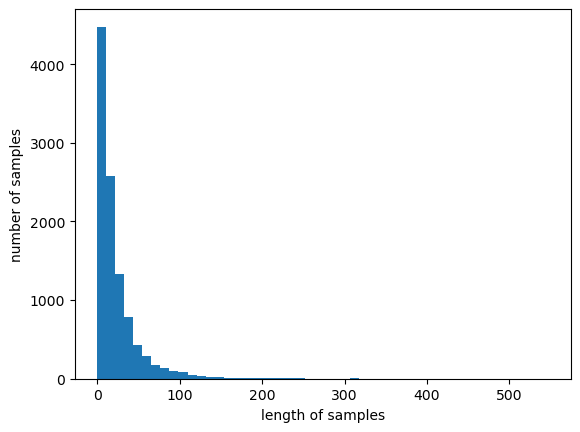

In [83]:
print('리뷰의 최대 길이 :',max(len(review) for review in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [84]:
def below_threshold_len(max_len, nested_list):
    count = 0
    for sentence in nested_list:
        if(len(sentence) <= max_len):
            count = count + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

max_len = 100
below_threshold_len(max_len, X_train)

X_train = pad_sequences(X_train, maxlen=max_len)
X_val = pad_sequences(X_val, maxlen=max_len)

전체 샘플 중 길이가 100 이하인 샘플의 비율: 97.4957474957475


In [85]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units))
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=64, validation_split=0.2)

Epoch 1/15
133/133 [==============================] - ETA: 0s - loss: 0.5996 - acc: 0.6717
Epoch 1: val_acc improved from -inf to 0.74539, saving model to best_model.h5
133/133 [==============================] - 21s 137ms/step - loss: 0.5996 - acc: 0.6717 - val_loss: 0.5178 - val_acc: 0.7454
Epoch 2/15
133/133 [==============================] - ETA: 0s - loss: 0.4671 - acc: 0.7823
Epoch 2: val_acc improved from 0.74539 to 0.77232, saving model to best_model.h5
133/133 [==============================] - 20s 148ms/step - loss: 0.4671 - acc: 0.7823 - val_loss: 0.4858 - val_acc: 0.7723
Epoch 3/15
133/133 [==============================] - ETA: 0s - loss: 0.4123 - acc: 0.8102
Epoch 3: val_acc improved from 0.77232 to 0.77515, saving model to best_model.h5
133/133 [==============================] - 18s 138ms/step - loss: 0.4123 - acc: 0.8102 - val_loss: 0.5059 - val_acc: 0.7752
Epoch 4/15
133/133 [==============================] - ETA: 0s - loss: 0.3858 - acc: 0.8284
Epoch 4: val_acc improve

In [86]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_val, y_val)[1]))

83/83 [==============================] - 2s 25ms/step - loss: 0.4646 - acc: 0.7865

 테스트 정확도: 0.7865


In [99]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import TimeoutException
from selenium.common.exceptions import NoSuchElementException
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import Select
import time
import requests
from bs4 import BeautifulSoup

import pandas as pd
import numpy as np
import re
from eunjeon import Mecab

import openpyxl
import os
import sys
import time
import json
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By

from geopy.geocoders import Nominatim

import warnings
warnings.filterwarnings('ignore')

In [104]:
def review_text(key, scroll):
    driver = webdriver.Chrome("chromedriver")
    url = "https://map.kakao.com/"
    driver.get(url)

    searchbox = driver.find_element(By.ID, 'search.keyword.query')
    searchbox.send_keys('서울 {}'.format(key))


    searchbutton = driver.find_element(By.ID, 'search.keyword.submit')
    driver.execute_script('arguments[0].click();', searchbutton)
    time.sleep(2)

    new_path = '//*[@id="info.search.place.list"]/li/div[4]/a'
    new_window = driver.find_element(By.XPATH, new_path)
    driver.execute_script('arguments[0].click();', new_window)
    time.sleep(2)

    driver.switch_to.window(driver.window_handles[-1])
    time.sleep(3)
    

    for i in range(scroll) :
        more = driver.find_elements(By.CSS_SELECTOR, 'span.txt_more')[0]
        driver.execute_script('arguments[0].click();', more)
        time.sleep(1) 

    review =  driver.find_elements(By.CSS_SELECTOR, 'div.comment_info>p')
    time.sleep(2)
#     rating = driver.find_elements(By.XPATH, '//*[@id="mArticle"]/div[7]/div/ul/li/div[2]/div/span/span') 
    rating = driver.find_elements(By.CSS_SELECTOR, 'div.star_info>div>span>span')
    time.sleep(2)

    re_lst = []
    rating_lst = []
    
    for x in review :
        re_lst.append(x.text)
    for y in rating :
        rating_lst.append(y.get_attribute('style'))
        
    return rating_lst, re_lst

In [106]:
part1 = pd.read_csv('part1.csv', encoding = 'cp949').drop(['Unnamed: 0'], axis = 1)[['Store', 'Category', 'FinalRating']]
part1 = part1.sort_values('FinalRating', ascending = False).reset_index(drop = True)

In [128]:
part1[:4]

,Store,Category,FinalRating
0,고른햇살,분식,16.149866
1,정편백,고기/육류,14.994337
2,힐사이드테이블,양식,14.976572
3,피자보이시나 신촌점,피자,14.430366


In [103]:
for i in range(2) : 
    print(i)

0
1


In [108]:
store = []
rating_lst = []
review_lst = []

key_lst = list(part1['Store'])[:3]
review_num = [163, 28, 117]

for i in range(3) : 

    key = key_lst[i]
    scroll = (review_num[i] - 3) // 5 

    rating, review = review_text(key, scroll) 

    store += [key] * len(rating)
    rating_lst += rating
    review_lst += review

In [109]:
test = pd.DataFrame({'Store' : store, 'Rating' : rating_lst, 'Review' : review_lst})

In [110]:
test

,Store,Rating,Review
0,고른햇살,width: 100%;,참치가 작아졌다가 다시 커져서 행복해요
1,고른햇살,width: 100%;,사람이 너무 많아서 포장해와서 먹어요 ㅎ ㅎ \n참김 최고존엄
2,고른햇살,width: 100%;,여기 개미침.
3,고른햇살,width: 100%;,떡볶이 라면 순대
4,고른햇살,width: 100%;,치즈김밥 너무 맛있어요
...,...,...,...
299,힐사이드테이블,width: 80%;,광화문의 깔끔한 샐러드 푸드코트 느낌. \n푸드코트 느낌은 셀프바와 키오스크\n테이...
300,힐사이드테이블,width: 80%;,
301,힐사이드테이블,width: 60%;,브런치 기대보다 못미침 단호박스프는 맛있음
302,힐사이드테이블,width: 20%;,


In [156]:
def sentiment_predict(new_sentence):
    
    encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
    pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
    score = float(loaded_model.predict(pad_new)) # 예측
    
    if(score > 0.5):
        ans = "{:.2f}".format(score * 100)
    else:
        ans = "-{:.2f}".format((1 - score) * 100)
        
    return ans

In [112]:
import re

new = []
mecab = Mecab()

with open('stopword.txt', 'r', encoding = 'utf8') as f:
    stop = f.read()
stop =  stop.split('\n')
add = ['는데', '네요', '어요', '너무', '아서', '보다', '해서', '다고', '정말', '많이', '맛있']
stop = stop + add

for txt in test['Review'] :
    
    text = re.compile('[^가-힣\s]').sub('', str(txt))  
    text = mecab.morphs(text)
    
    text = [x for x in text if x not in stop]
    
    new.append(text)
    
test['new_text'] = new
test.head()

,Store,Rating,Review,new_text
0,고른햇살,width: 100%;,참치가 작아졌다가 다시 커져서 행복해요,"[참치, 작아졌, 다가, 다시, 커져서, 행복]"
1,고른햇살,width: 100%;,사람이 너무 많아서 포장해와서 먹어요 ㅎ ㅎ \n참김 최고존엄,"[사람, 많, 포장, 해, 와서, 먹, 참김, 최고, 존엄]"
2,고른햇살,width: 100%;,여기 개미침.,"[개미, 침]"
3,고른햇살,width: 100%;,떡볶이 라면 순대,"[떡볶이, 라면, 순대]"
4,고른햇살,width: 100%;,치즈김밥 너무 맛있어요,"[치즈, 김밥]"


In [157]:
answer = []
for x in test['new_text'] :
    ans = sentiment_predict(x)
    answer.append(ans)
    
test['Answer2'] = answer

1/1 [==============================] - 0s 26ms/step


In [161]:
test['Answer2'] = test['Answer2'].astype('float')

In [168]:
pos = test[test['Answer2'] > 0][['Store', 'new_text', 'Answer']]

pos0 = []
for x in pos['new_text'] :
    pos0 += x

stop = ['김밥', '도', '고', '합니다', '입니다', '세요', '어요', '아요', '참치', '라볶이', '치즈', '샐러드', '음식']
pos0 = [x for x in pos0 if x not in stop]
pos0 = [x for x in pos0 if len(x) >1]
    
wc = dict(Counter(pos0).most_common(100))

cloud = stylecloud.gen_stylecloud(text = wc, font_path = "malgun", icon_name = "fas fa-utensils", background_color = 'white', 
                                 output_name = '{}.png'.format('긍정'))

In [180]:
neg = test[test['Answer2'] < 0][['Rating', 'Review', 'Answer']]
neg.sort_values('Answer')

,Rating,Review,Answer
106,4,"가성비, 정겨운 분식집 분위기",-51.42%
24,5,비싸졌지만 그래도 맛있다,-52.24%
105,5,떡볶이는 맵네. 담부턴 떡볶이는 빼고 시켜야겠다. 복코빌지수 8/5,-52.72%
137,2,"가성비는 좋지만, 음식의 질이 들쭉날쭉 합니다. 물론 그마저도 가격을 감안하면 이해...",-54.58%
51,1,이젠 들기름을 안쓰시네요 ㅜㅜ 휴 맛이,-54.61%
...,...,...,...
92,4,참치김밥이랑 라면은 국룰입니다ㅎㅎ\n라볶이랑 다른 메뉴 시켰는데 사실 평범했어요..,-98.75%
226,3,감자수프가 왜이리 차갑나요\n다른건 그냥저냥 먹을만 했어요,-98.86%
25,1,맛은 그저 그렇고 서비스는 최악\n물어봐도 개무시함,-99.00%
281,3,천원씩 추가해야하는 수비드와 다른 메뉴는 두시 좀 넘어 갔는데 품절이었다 세시반까지...,-99.40%


In [191]:
neg = test[test['Answer2'] < 0][['Store', 'new_text', 'Answer']]

neg0 = []
for x in neg['new_text'] :
    neg0 += x

stop = ['김밥', '도', '고', '합니다', '입니다', '세요', '어요', '아요', '참치', '라볶이', '치즈', '샐러드', '음식', '라고', '메뉴', '괜찮',
       '정도', '샌드위치', '가격', '사람', '기대', '어서', '단호박', '연어', '치킨', '특히', '두부', '델리', '진짜', '방문', '친절', '인데', 
        '느낌', '만들', '이랑', '크림', '직원', '가성']
neg0 = [x for x in neg0 if x not in stop]
neg0 = [x for x in neg0 if len(x) >1]
    
wc = dict(Counter(neg0).most_common(80))

cloud = stylecloud.gen_stylecloud(text = wc, font_path = "malgun", icon_name = "fas fa-utensil-spoon", background_color = 'white', 
                                 output_name = '{}.png'.format('부정22'))

In [127]:
test = test.replace({'width: 100%;' : 5, 'width: 80%;' : 4, 'width: 60%;' : 3, 'width: 40%;' : 2, 'width: 20%;' : 1})
test[test['Store'] == '고른햇살'][['Store', 'Rating', 'Review', 'Answer']].sort_values('Answer')

,Store,Rating,Review,Answer
106,고른햇살,4,"가성비, 정겨운 분식집 분위기",-51.42%
24,고른햇살,5,비싸졌지만 그래도 맛있다,-52.24%
105,고른햇살,5,떡볶이는 맵네. 담부턴 떡볶이는 빼고 시켜야겠다. 복코빌지수 8/5,-52.72%
137,고른햇살,2,"가성비는 좋지만, 음식의 질이 들쭉날쭉 합니다. 물론 그마저도 가격을 감안하면 이해...",-54.58%
51,고른햇살,1,이젠 들기름을 안쓰시네요 ㅜㅜ 휴 맛이,-54.61%
...,...,...,...,...
111,고른햇살,5,참김에 치즈라볶이 조합 최고에요,97.08%
1,고른햇살,5,사람이 너무 많아서 포장해와서 먹어요 ㅎ ㅎ \n참김 최고존엄,97.16%
146,고른햇살,5,참치김밥 엄청 크고 참치가 가득 차있어요! 가성비 갑이구요 비냉도 시켜먹었는데 참기...,97.96%
11,고른햇살,5,제육김밥 전보다 많이 매워진거같아요 혀가아팠음 매운거 잘 못드시는 분들은 참고하세요...,98.58%


In [130]:
test[test['Store'] == '힐사이드테이블'][['Store', 'Rating', 'Review', 'Answer']]

,Store,Rating,Review,Answer
191,힐사이드테이블,4,건강하게 맛있는 곳 가격이 아쉽!,53.82%
192,힐사이드테이블,4,야채가 약간 시들시들 막 맛있다 이정도는 아니고 건강한 맛있다,53.13%
193,힐사이드테이블,3,만들어놓은 음식 데워주는 곳인 줄 몰랐음. 그마저도 미지근 ㅋㅋ\n(음식이 주문하고...,-97.47%
194,힐사이드테이블,5,사랑한다,97.02%
195,힐사이드테이블,5,맛있어요! 비건푸드도 맛있을 수 있군요!,-90.05%
...,...,...,...,...
299,힐사이드테이블,4,광화문의 깔끔한 샐러드 푸드코트 느낌. \n푸드코트 느낌은 셀프바와 키오스크\n테이...,-96.86%
300,힐사이드테이블,4,,70.29%
301,힐사이드테이블,3,브런치 기대보다 못미침 단호박스프는 맛있음,-88.82%
302,힐사이드테이블,1,,70.29%


In [187]:
k = test[test['Store'] == '정편백'][['Store', 'Rating', 'Review', 'Answer2']]
np.mean(k['Answer2'])

32.153571428571425

In [134]:
test[test['Store'] == '정편백'][['Store', 'Rating', 'Review', 'Answer']].drop([166, 167], axis = 0)

,Store,Rating,Review,Answer
163,정편백,2,반찬들이 미리 퍼놓고 오래있었는지 다 말라있었음. 고기나 야채들이 뭔가 다 작았다고...,-91.39%
164,정편백,5,존맛ㅠㅠ 우삼겹 목심 둘다 맛있고 큰 차이는 느껴지지 않으나 확실히 우삼겹이 마블링...,78.17%
165,정편백,1,직원이 불친절해여~~,-87.67%
168,정편백,5,여기 알바 존잘임 맛있음,85.96%
169,정편백,3,바쁘다고 그릇 소리나게 탁탁 던져놓고 눈치보여서 반찬 더 달라고 하기도 힘든 곳,-84.19%
170,정편백,3,맛있음 ㅇㅇ\n근데 가서 혹시나 싶어서 물티슈로 밥상 닦는데 진짜 진한회색빛.. 충...,80.56%
171,정편백,4,우삼겹 편백찜에 시그니처 정라면까지 머꼬와써\n건강한 맛인 편백찜은 소스에 찍어먹는...,-89.66%
172,정편백,3,편백찜이야 맛없기 힘든 음식이라 맛있게 먹었습니다.\n반찬이랑 냉모밀도 맛있고 양도...,-95.51%
173,정편백,3,,70.29%
174,정편백,5,개인적으로 훌륭한 맛이라고 생각됩니다. 직원 분들도 친절하시고 전반적인 경험이 좋은...,-55.80%


In [154]:
jung_df = test[test['Store'] == '정편백'][['Store', 'new_text', 'Answer']]
jung = []
for x in jung_df['new_text'] :
    jung += x

stop = ['김밥', '도', '고', '합니다', '입니다', '세요', '어요', '아요', '참치']
jung = [x for x in jung if x not in stop]
jung = [x for x in jung if len(x) >1]
    
wc = dict(Counter(jung).most_common(100))

cloud = stylecloud.gen_stylecloud(text = wc, font_path = "malgun", icon_name = "fas fa-utensils", background_color = 'white', 
                                 output_name = '{}.png'.format('정편백'))

In [184]:
sun_df = test[test['Store'] == '고른햇살'][['Store', 'new_text', 'Answer', 'Answer2']]
np.mean(test['Answer2'])

16.58565789473685

In [185]:
np.mean(test['Answer2'])

16.58565789473685

In [139]:
sun = []
for x in sun_df['new_text'] :
    sun += x
sun

['참치',
 '작아졌',
 '다가',
 '다시',
 '커져서',
 '행복',
 '사람',
 '많',
 '포장',
 '해',
 '와서',
 '먹',
 '참김',
 '최고',
 '존엄',
 '개미',
 '침',
 '떡볶이',
 '라면',
 '순대',
 '치즈',
 '김밥',
 '참김',
 '라볶이',
 '성비',
 '가격',
 '은',
 '올랐',
 '가성',
 '비',
 '맛집',
 '이렇게',
 '달',
 '고',
 '맛없',
 '는',
 '제육',
 '김밥',
 '은',
 '처음',
 '먹',
 '봄',
 '다',
 '남김',
 '자주',
 '방문',
 '했',
 '던',
 '가게',
 '인데',
 '맛',
 '변했',
 '참치',
 '김밥',
 '라',
 '붂이',
 '게',
 '먹',
 '었',
 '위생',
 '의심',
 '되',
 '는',
 '경험',
 '회',
 '있',
 '었',
 '음',
 '비추',
 '제육',
 '김밥',
 '전',
 '매워',
 '진',
 '거',
 '같',
 '아요',
 '혀',
 '아팠',
 '음',
 '매운',
 '거',
 '잘',
 '못',
 '드',
 '시',
 '는',
 '분',
 '은',
 '참고',
 '세요',
 '어쨌든',
 '게',
 '도',
 '깔끔',
 '해',
 '지',
 '고',
 '저렴',
 '고',
 '푸짐',
 '한',
 '고른',
 '햇살',
 '최고',
 '제육',
 '참치',
 '제육',
 '더',
 '음',
 '한양대',
 '푸른',
 '햇살',
 '갔',
 '가성',
 '비',
 '좋',
 '아요',
 '김밥',
 '도',
 '두껍',
 '고',
 '라볶이',
 '도',
 '처음',
 '갔',
 '뭣',
 '도',
 '모르',
 '고',
 '점심',
 '명',
 '서',
 '원',
 '시켰',
 '다가',
 '다',
 '배',
 '터져서',
 '날',
 '아침',
 '아무',
 '도',
 '못',
 '먹',
 '음',
 '처음',
 '갔',
 '던',
 '전',
 '가격',
 '은',


In [152]:
import stylecloud
wc = dict(Counter(sun).most_common(100))

cloud = stylecloud.gen_stylecloud(text = wc, font_path = "malgun", icon_name = "fas fa-utensils", background_color = 'white', 
                                 output_name = '{}.png'.format('고른햇살'))

In [151]:
stop = ['김밥', '도', '고', '합니다', '입니다', '세요', '어요', '아요', '참치']
sun = [x for x in sun if x not in stop]
sun = [x for x in sun if len(x) >1]